In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.option("header", True).csv("/FileStore/tables/tweets_with_sentiments_label.csv")
df.printSchema()

root
-- _c0: string (nullable = true)
-- id: string (nullable = true)
-- text: string (nullable = true)
-- label: string (nullable = true)

In [ ]:
df.show()

+---+-------------------+--------------------+----------------+
_c0| id| text| label|
+---+-------------------+--------------------+----------------+
 0|1222012694011629568|The Wuhan Virus: ...| negative|
 1|1222070690007920640|@Jimmyjude13 Well...| negative|
 2|1222070757120974849|US to expand viru...| negative|
 3|1222070810581655553|@DrOz: Reports su...| negative|
 4|1222070816076107781|Wuhan in lock dow...|neutral or mixed|
 5|1222071030891581440|This is NOT A MOV...| negative|
 6|1222071061044330497|I know this is no...| negative|
 7|1222071107475460101|@maggieNYT Cant w...| negative|
 8|1222071199657754624|@RepGosar @Cernov...| negative|
 9|1222071274454880256|@PoliticalKathy B...|neutral or mixed|
 10|1222071435713110016|7 Wuhan virus cas...| negative|
 11|1222071473629691905|With Wuhan virus ...| negative|
 12|1222071472895746052|Bookmark this pag...| negative|
 13|1222071697559511040|Stars and dust in...| positive|
 14|1222071713770483712|Corona Virus danc...|neutral or mixed|
 15|1222071867600592896|This is NOT A MOV...| negative|
 16|1222072048354086912|Isnt Wuhan that m...| negative|
 17|1222072103983296512|The Wuhan corona ...| negative|
 18|1222072103983296512|The Wuhan corona ...| negative|
 19|1222072117757403137|China knew about ...| negative|
+---+-------------------+--------------------+----------------+
only showing top 20 rows

In [ ]:
df.createOrReplaceTempView("tweet_data")
df1 = spark.sql('''
select 
id, 
`text`, 
case when label = "negative" then 0 else 1 end  as label     
from tweet_data
''')

In [ ]:
df1.show()

+-------------------+--------------------+-----+
 id| text|label|
+-------------------+--------------------+-----+
1222012694011629568|The Wuhan Virus: ...| 0|
1222070690007920640|@Jimmyjude13 Well...| 0|
1222070757120974849|US to expand viru...| 0|
1222070810581655553|@DrOz: Reports su...| 0|
1222070816076107781|Wuhan in lock dow...| 1|
1222071030891581440|This is NOT A MOV...| 0|
1222071061044330497|I know this is no...| 0|
1222071107475460101|@maggieNYT Cant w...| 0|
1222071199657754624|@RepGosar @Cernov...| 0|
1222071274454880256|@PoliticalKathy B...| 1|
1222071435713110016|7 Wuhan virus cas...| 0|
1222071473629691905|With Wuhan virus ...| 0|
1222071472895746052|Bookmark this pag...| 0|
1222071697559511040|Stars and dust in...| 1|
1222071713770483712|Corona Virus danc...| 1|
1222071867600592896|This is NOT A MOV...| 0|
1222072048354086912|Isnt Wuhan that m...| 0|
1222072103983296512|The Wuhan corona ...| 0|
1222072103983296512|The Wuhan corona ...| 0|
1222072117757403137|China knew about ...| 0|
+-------------------+--------------------+-----+
only showing top 20 rows

In [ ]:
# df1.createOrReplaceTempView("tweet_data")
df1 = df1.dropna()
df1.printSchema()
df1.show()


root
-- id: string (nullable = true)
-- text: string (nullable = true)
-- label: integer (nullable = false)

+-------------------+--------------------+-----+
 id| text|label|
+-------------------+--------------------+-----+
1222012694011629568|The Wuhan Virus: ...| 0|
1222070690007920640|@Jimmyjude13 Well...| 0|
1222070757120974849|US to expand viru...| 0|
1222070810581655553|@DrOz: Reports su...| 0|
1222070816076107781|Wuhan in lock dow...| 1|
1222071030891581440|This is NOT A MOV...| 0|
1222071061044330497|I know this is no...| 0|
1222071107475460101|@maggieNYT Cant w...| 0|
1222071199657754624|@RepGosar @Cernov...| 0|
1222071274454880256|@PoliticalKathy B...| 1|
1222071435713110016|7 Wuhan virus cas...| 0|
1222071473629691905|With Wuhan virus ...| 0|
1222071472895746052|Bookmark this pag...| 0|
1222071697559511040|Stars and dust in...| 1|
1222071713770483712|Corona Virus danc...| 1|
1222071867600592896|This is NOT A MOV...| 0|
1222072048354086912|Isnt Wuhan that m...| 0|
1222072103983296512|The Wuhan corona ...| 0|
1222072103983296512|The Wuhan corona ...| 0|
1222072117757403137|China knew about ...| 0|
+-------------------+--------------------+-----+
only showing top 20 rows

In [ ]:
train, test = df1.randomSplit([0.8, 0.2])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 743734
Test Dataset Count: 185711

In [ ]:
train.show()

+--------------------+--------------------+-----+
 id| text|label|
+--------------------+--------------------+-----+
#coronaviruswuhan...| negative| 1|
... No occupants ...| negative| 1|
... The disturbin...| neutral or mixed| 1|
 1222012694011629568|The Wuhan Virus: ...| 0|
 1222070690007920640|@Jimmyjude13 Well...| 0|
 1222070757120974849|US to expand viru...| 0|
 1222070810581655553|@DrOz: Reports su...| 0|
 1222070816076107781|Wuhan in lock dow...| 1|
 1222071030891581440|This is NOT A MOV...| 0|
 1222071199657754624|@RepGosar @Cernov...| 0|
 1222071274454880256|@PoliticalKathy B...| 1|
 1222071435713110016|7 Wuhan virus cas...| 0|
 1222071472895746052|Bookmark this pag...| 0|
 1222071473629691905|With Wuhan virus ...| 0|
 1222071697559511040|Stars and dust in...| 1|
 1222072048354086912|Isnt Wuhan that m...| 0|
 1222072103983296512|The Wuhan corona ...| 0|
 1222072117757403137|China knew about ...| 0|
 1222072329401851904|"@cnni During the...| 1|
 1222072329678868480|@Tsii_96 @BaBaBla...| 0|
+--------------------+--------------------+-----+
only showing top 20 rows

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

# Logistic Regression

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
model = pipeline.fit(train, params=None)
predictions = model.transform(test)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7114715588518297

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

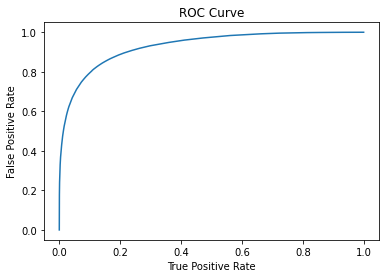

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

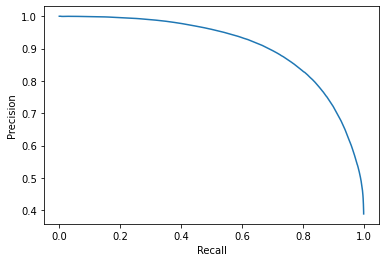

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
train_summary = model.stages[-1].summary
roc = train_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = train_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(maxDepth = 2)
dtPipeline = Pipeline(stages=[tokenizer, hashingTF, dt])
dtModel = dtPipeline.fit(train)
dtPredictions = dtModel.transform(test)
dtEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', dtEval.evaluate(dtPredictions))

Test Area Under ROC 0.5640952497452871

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
train_summary = model.stages[-1].summary
roc = train_summary.roc.toPandas()
dtTrainSummary = dtModel.stages[-1]
roc = dtTrainSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = dtTrainSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier()
rfPipeline = Pipeline(stages=[tokenizer, hashingTF, rf])
rfModel = rfPipeline.fit(train)
rfPredictions = rfModel.transform(test)
rfModelEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', rfModelEval.evaluate(rfPredictions))

Test Area Under ROC 0.5966808246111149